In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn
import pandas
import os
import warnings
import datetime
import sys
import matplotlib
import scipy
import re
from scipy.sparse import coo_matrix

font = {"family": "serif",
        "weight": "normal",
        "size": 15}

matplotlib.rc("font", **font)
matplotlib.rcParams["figure.figsize"] = (8, 6)
matplotlib.rcParams['figure.dpi'] = 75

# The gist

The basic definition of the Jacobi solver is:

$x^{k+1} = \left(b - Lx^k \right) D^{-1}$

where $D$ is the diagonal and $L$ are the off-diagonal terms of the matrix $A$.

Noting that the residual of the equation system (Eq. 2 in Weymouth (2020)) is given as

$r^k = b - Ax^k$

the Jacobi equation can be rewritten as

$x^{k+1} = \left\lbrack b - (L+D)x^k + Dx^k \right\rbrack D^{-1} = \left\lbrack b - Ax^k + Dx^k \right\rbrack D^{-1} = r^k D^{-1} + x^k$

Threfore, the update of the solution vector at a given iteration is defined as

$\epsilon = D^{-1} r^k$

This can be generalised by defining an approximate of the matrix inverse, $\tilde{A}^{-1}$:

$\epsilon = \tilde{A}^{-1} r^k$

In Weymouth (2020), this is done by constructing a quadratic polynomial that uses the off-diagonal terms (Eq. 6 in the paper).

In [3]:
# PETSC-formatted matrix import.

def readPetscMatrix(filename):
    # Read and upack the compact row storage format.
    with open(filename, 'rt', encoding='ascii') as infile:
        fString = infile.readlines()
    A_vals = []
    A_rows = []
    A_cols = []
    for line in fString:
        if line.startswith("row"):
            iRow = int(line.split(":")[0].split()[1])
            vals = [v.strip("()").split(",") for v in re.findall("\([0-9]+,.*?\)", line)]
            for v in vals:
                A_rows.append(iRow); A_cols.append(int(v[0])); A_vals.append(float(v[1]))
    # Convert to a sparse matrix.
    return coo_matrix((A_vals, (A_rows, A_cols)))

def readPetscVector(filename):
    with open(filename, 'rt', encoding='ascii') as infile:
        fString = infile.readlines()
    b = []
    for line in fString:
        try:
            b.append(float(line.strip()))
        except ValueError:
            pass
    return np.array(b)

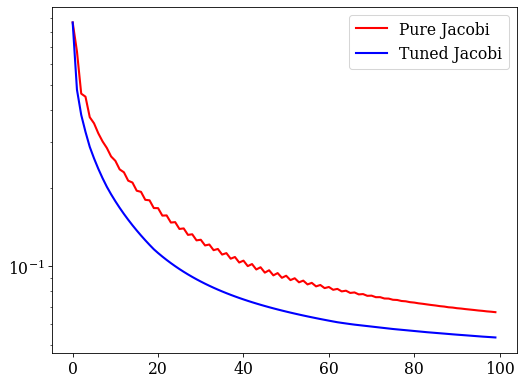

In [13]:
def TunedJacobi(A, b, Nmax=100, x0=None, tol=1e-3, p=[-0.104447, -0.00238399, 0.00841367, -0.158046, -0.115103]):
    if x0 is None:
        x = np.zeros(len(b))
    else:
        x = x0.copy()
    
    def Dm(D):
        return 1. + p[0] + D*(p[1] + D*p[2])

    def Lm(L):
        return L*(p[3]*(L-2) + p[4]*(L-1))

    # Scaling factor of the matrix terms (see below Eq. 6 of Weymouth (2020)).
    scale = np.max(A - np.diagflat(np.diag(A)))

    # Compute the approximate inverse.
    Dp = np.zeros(A.shape[0])
    Lp = np.zeros(A.shape)
    for I in range(A.shape[0]):
        # The diagonal term.
        if abs(A[I, I]) < 1e-8:
            invD = 0.
        else:
            invD = 1./A[I, I]
        Dp[I] = invD*Dm(A[I, I]/scale)

        # Lower-diagonal terms.
        for J in range(A.shape[0]):
            if J == I:
                continue

            if abs(A[I, I] + A[J, J]) < 2e-8:
                invD = 0.
            else:
                invD = 2. / (A[I, I] + A[J, J])
            Lp[I, J] = invD*Lm(A[I, J]/scale)

    # Solve.
    convHist = []
    for i in range(Nmax):
        # Compute the residual
        r = b - np.dot(A, x)
        # Perfrom the update step.
        x = x + np.dot(np.diagflat(Dp)+Lp, r)
        # Compute and store the convergence criterion.
        res = np.linalg.norm(r, np.inf)
        convHist = np.append(convHist, res)
        if res < tol:
            break
        
    return x, convHist, i

# Read example data.
# case = "D:/2024_inno4scale_exaSIMPLE/data_2_DDGAMG/data_Nc_32_2D-dipole_1"
case = "./exampleData_2_Weymouth2020/data_Nc_32_2D-sphere_1"
# case = "D:/2024_inno4scale_exaSIMPLE/data_2_DDGAMG/data_Nc_32_2D-static_1"
A = readPetscMatrix(case+"_A.dat").toarray()
b = readPetscVector(case+"_b.dat")

# Test
x, res, nIter = TunedJacobi(A, b, tol=1e-24, p=np.zeros(5))
x_t, res_t, nIter_t = TunedJacobi(A, b, tol=1e-24)

# Plot convergence.
plt.plot(res, "r-", lw=2, label="Pure Jacobi")
plt.plot(res_t, "b-", lw=2, label="Tuned Jacobi")
plt.yscale("log")
plt.legend()